In [1]:
import pandas as pd
from scipy.stats import ttest_ind, levene, mannwhitneyu,shapiro, \
    f_oneway, kruskal, chi2_contingency, fisher_exact
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
import pingouin as pg
from statsmodels.graphics.mosaicplot import mosaic

#pd.set_option('display.max_rows', None)  # Отображение всех строк  
pd.set_option('display.max_columns', None)  # Отображение всех столбцов  

In [33]:
dtp = pd.read_csv('DTP.csv')
dtp

,Unnamed: 0,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,n_INJURED,vehicle_failure,non_private_vehicle,russian_vehicle,white_vehicle,black_vehicle,colored_vehicle,drunk_driver,female_driver,escaped,no_seatbelt_injury,n_drunk,n_children,n_cyclists,n_pedestrians,vehicle_age_min,vehicle_age_max,vehicle_age_avg,n_class_a,n_class_b,n_class_c,n_class_d,n_class_e,n_class_s,n_front_drive,n_rear_drive,n_4wd,n_guilty,guilty_share,n_fatal_violations,guilty_exp_avg,exp_avg,road_rank_cat,road_defects_cat,traffic_changes_bin,traffic_changes_cat,road_surface_cat,TYPE_cat,out_of_town,street_rank_cat,weather_interpretable,weather_cat,adj_objects_interpretable,adj_objects_cat,cause_factors_cat,crossing_violation,impaired_driving,interference_violation,license_violation,maneuver_violation,other_violation,pedestrian_violation,sudden_appearance_violation,traffic_control_violation,transport_violation,vehicle_tech_violation,wrong_way,no_lighting,lighting_cat,site_objects_cat,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR
0,6,1,31.01.2015,81.151944,53.740000,Романово - Завьялово - Баево - Камень-на-Оби,5.0,1,3,161242174,0,3,0,0,0,0,0,1,0,0,1,1,0,0,0,0,2003.0,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,4,17.0,17.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,1,0,0,0,1,0,0,0,4,12,2,2015,1,5,1,1,9,0,1
1,8,1,30.01.2015,85.018056,51.684444,Куяган - Куяча - Тоурак,6.0,2,3,161105683,0,2,0,1,0,1,0,1,0,0,0,0,0,0,0,0,2002.0,2004.0,2003.0,1,0,0,0,0,0,0,0,0,1,0.5,1,7.0,10.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,2,2015,1,4,1,0,14,0,0
2,12,1,30.01.2015,81.250000,53.818056,Барнаул - Камень-на-Оби - граница Новосибирско...,5.0,2,3,161763431,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2005.0,2008.0,2006.5,0,1,0,0,0,0,0,0,0,1,0.5,1,2.0,15.5,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,1,2015,1,4,1,0,17,0,1
3,39,1,24.01.2015,51.000000,84.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160331994,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,2000.0,2000.0,2000.0,0,1,0,0,0,0,0,0,0,1,1.0,2,26.0,26.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,1,0,0,0,0,0,0,1,0,0,0,1,2,12,1,2015,1,5,1,1,19,0,0
4,42,1,23.01.2015,84.000000,53.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160213415,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2003.0,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,1,18.0,18.0,3,5,0,2,1,7,1,0,LOW_VISIBILITY,3,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,12,3,2015,1,4,1,0,21,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473183,1475642,10011,18.12.2022,55.731164,67.417464,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",5.0,1,1,222679998,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,2020.0,2020.0,2020.0,0,0,0,0,0,0,0,0,1,1,1.0,1,31.0,31.0,3,5,0,2,1,7,1,4,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,3,2022,12,6,1,1,15,0,0
473184,1475665,10011,16.06.2024,54.095821,67.629532,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",6.0,1,2,223892751,0,2,0,0,0,0,1,0,1,0,0,1,2,0,0,0,2023.0,2023.0,2023.0,0,0,0,1,0,0,0,0,1,1,1.0,4,8.0,8.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,1,1,0,0,0,0,12,1,2024,6,6,3,1,9,0,1
473185,1475669,10011,04.07.2024,53.607541,67.836463,Подъездная автомобильная дорога к п. Красное,1.0,1,1,223948754,0,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,2011.0,2011.0,2011.0,0,0,0,0,0,0,0,0,0,1,1.0,1,24.0,24.0,3,13,0,2,2,7,1,4,LOW_VISIBILITY,3,LIVING_OBJ,1,18,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,2,2024,7,3,3,0,9,0,1
473186,1475671,10011,25.08.2024,53.612724,67.837285,Подъездная автомобильная дорога к п. Красное,4.0,1,1,224161731,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,2024.0,2024.0,2024.0,0,0,0,0,0,0,0,0,0,1,1.0,4,95.0,95.0,3,5,0,2,7,4,1,4,nothing,5,SOCIAL_OBJ,3,18,0,0,0,1,0,1,0,0,1,1,0,0,0,0,12,1,2024,

In [34]:
dtp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473188 entries, 0 to 473187
Data columns (total 80 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   473188 non-null  int64  
 1   REGION                       473188 non-null  int64  
 2   DATE                         473188 non-null  object 
 3   COORD_L                      473188 non-null  float64
 4   COORD_W                      473188 non-null  float64
 5   road_name                    473188 non-null  object 
 6   road_category                473188 non-null  float64
 7   n_VEHICLES                   473188 non-null  int64  
 8   n_PARTICIPANTS               473188 non-null  int64  
 9   ID                           473188 non-null  int64  
 10  n_DEATHS                     473188 non-null  int64  
 11  n_INJURED                    473188 non-null  int64  
 12  vehicle_failure              473188 non-null  int64  
 13 

In [23]:
dtp['vehicle_age_min_2'] = dtp['YEAR'] - dtp['vehicle_age_min']

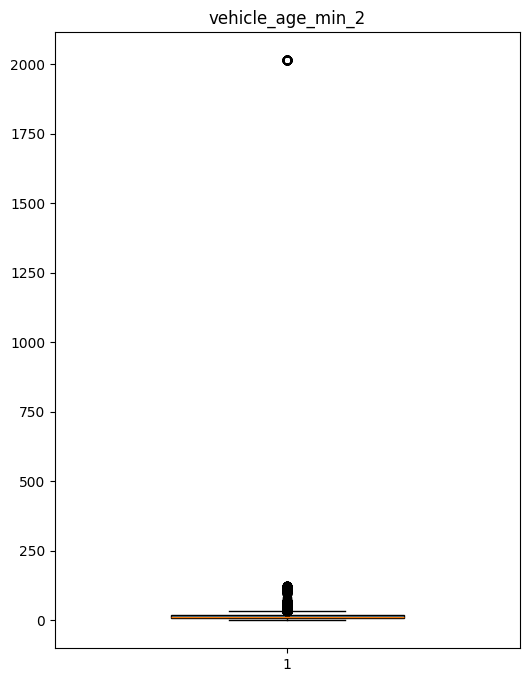

In [24]:
x = dtp['vehicle_age_min_2']

fig, ax = plt.subplots(figsize=(6, 8))

# --- Рисуем boxplot ---
box = ax.boxplot(
    x,
    widths=0.5,
    patch_artist=True
)

# --- Достаём PathPatch коробки ---
box_patch = box['boxes'][0]
path = box_patch.get_path()
vertices = path.vertices

# Левый и правый X коробки
box_x_left = vertices[:, 0].min()
box_x_right = vertices[:, 0].max()

ax.set_title("vehicle_age_min_2")
plt.show()

In [25]:
dtp = dtp.drop(dtp.loc[dtp['vehicle_age_min_2'] > 500].index)

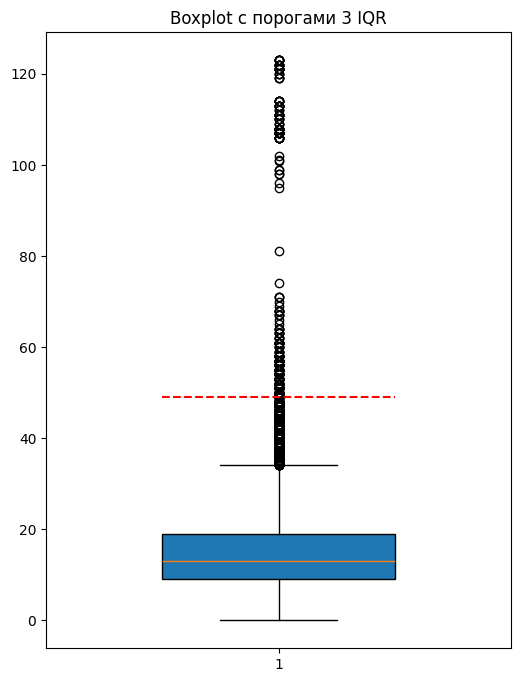

In [26]:
x = dtp['vehicle_age_min_2']

Q1 = x.quantile(0.25)
Q3 = x.quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 3 * IQR
upper = Q3 + 3 * IQR

fig, ax = plt.subplots(figsize=(6, 8))

# --- Рисуем boxplot ---
box = ax.boxplot(
    x,
    widths=0.5,
    patch_artist=True
)

# --- Достаём PathPatch коробки ---
box_patch = box['boxes'][0]
path = box_patch.get_path()
vertices = path.vertices

# Левый и правый X коробки
box_x_left = vertices[:, 0].min()
box_x_right = vertices[:, 0].max()

# --- Рисуем короткие красные линии ---
#ax.hlines(lower, box_x_left, box_x_right, colors='red', linestyles='--')
ax.hlines(upper, box_x_left, box_x_right, colors='red', linestyles='--')

ax.set_title("Boxplot с порогами 3 IQR")
plt.show()

In [27]:
dtp = dtp.loc[dtp.vehicle_age_min_2 <= upper]

In [17]:
dtp

,Unnamed: 0,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,n_INJURED,vehicle_failure,non_private_vehicle,russian_vehicle,white_vehicle,black_vehicle,colored_vehicle,drunk_driver,female_driver,escaped,no_seatbelt_injury,n_drunk,n_children,n_cyclists,n_pedestrians,vehicle_age_min,vehicle_age_max,vehicle_age_avg,n_class_a,n_class_b,n_class_c,n_class_d,n_class_e,n_class_s,n_front_drive,n_rear_drive,n_4wd,n_guilty,guilty_share,n_fatal_violations,guilty_exp_avg,exp_avg,road_rank_cat,road_defects_cat,traffic_changes_bin,traffic_changes_cat,road_surface_cat,TYPE_cat,out_of_town,street_rank_cat,weather_interpretable,weather_cat,adj_objects_interpretable,adj_objects_cat,cause_factors_cat,crossing_violation,impaired_driving,interference_violation,license_violation,maneuver_violation,other_violation,pedestrian_violation,sudden_appearance_violation,traffic_control_violation,transport_violation,vehicle_tech_violation,wrong_way,no_lighting,lighting_cat,site_objects_cat,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR,vehicle_age_min_2,vehicle_age_max_2
0,6,1,31.01.2015,81.151944,53.740000,Романово - Завьялово - Баево - Камень-на-Оби,5.0,1,3,161242174,0,3,0,0,0,0,0,1,0,0,1,1,0,0,0,0,2003.0,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,4,17.0,17.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,1,0,0,0,1,0,0,0,4,12,2,2015,1,5,1,1,9,0,1,12.0,12.0
1,8,1,30.01.2015,85.018056,51.684444,Куяган - Куяча - Тоурак,6.0,2,3,161105683,0,2,0,1,0,1,0,1,0,0,0,0,0,0,0,0,2002.0,2004.0,2003.0,1,0,0,0,0,0,0,0,0,1,0.5,1,7.0,10.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,2,2015,1,4,1,0,14,0,0,13.0,11.0
2,12,1,30.01.2015,81.250000,53.818056,Барнаул - Камень-на-Оби - граница Новосибирско...,5.0,2,3,161763431,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2005.0,2008.0,2006.5,0,1,0,0,0,0,0,0,0,1,0.5,1,2.0,15.5,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,1,2015,1,4,1,0,17,0,1,10.0,7.0
3,39,1,24.01.2015,51.000000,84.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160331994,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,2000.0,2000.0,2000.0,0,1,0,0,0,0,0,0,0,1,1.0,2,26.0,26.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,1,0,0,0,0,0,0,1,0,0,0,1,2,12,1,2015,1,5,1,1,19,0,0,15.0,15.0
4,42,1,23.01.2015,84.000000,53.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160213415,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2003.0,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,1,18.0,18.0,3,5,0,2,1,7,1,0,LOW_VISIBILITY,3,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,12,3,2015,1,4,1,0,21,0,0,12.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473183,1475642,10011,18.12.2022,55.731164,67.417464,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",5.0,1,1,222679998,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,2020.0,2020.0,2020.0,0,0,0,0,0,0,0,0,1,1,1.0,1,31.0,31.0,3,5,0,2,1,7,1,4,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,3,2022,12,6,1,1,15,0,0,2.0,2.0
473184,1475665,10011,16.06.2024,54.095821,67.629532,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",6.0,1,2,223892751,0,2,0,0,0,0,1,0,1,0,0,1,2,0,0,0,2023.0,2023.0,2023.0,0,0,0,1,0,0,0,0,1,1,1.0,4,8.0,8.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,1,1,0,0,0,0,12,1,2024,6,6,3,1,9,0,1,1.0,1.0
473185,1475669,10011,04.07.2024,53.607541,67.836463,Подъездная автомобильная дорога к п. Красное,1.0,1,1,223948754,0,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,2011.0,2011.0,2011.0,0,0,0,0,0,0,0,0,0,1,1.0,1,24.0,24.0,3,13,0,2,2,7,1,4,LOW_VISIBILITY,3,LIVING_OBJ,1,18,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,2,2024,7,3,3,0,9,0,1,13.0,13.0
473186,1475671,10011,25.08.2024,53.612724,67.837285,Подъездная автомобильная дорога к п. Красное,4.0,1,1,224161731,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,2024.0,2024.0,2024

<Axes: xlabel='n_PARTICIPANTS', ylabel='n_DEATHS'>

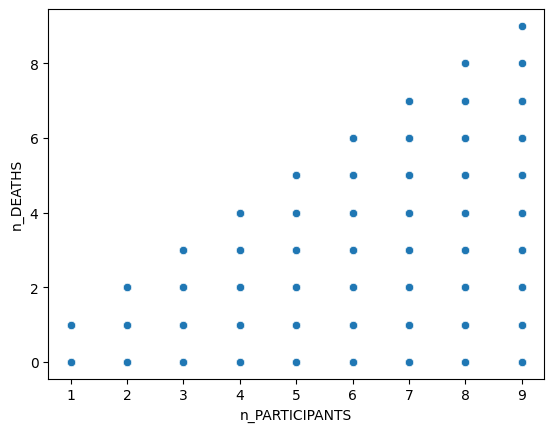

In [18]:
sns.scatterplot(data = dtp, x = 'n_PARTICIPANTS', y = 'n_DEATHS')

<Axes: xlabel='n_PARTICIPANTS', ylabel='n_INJURED'>

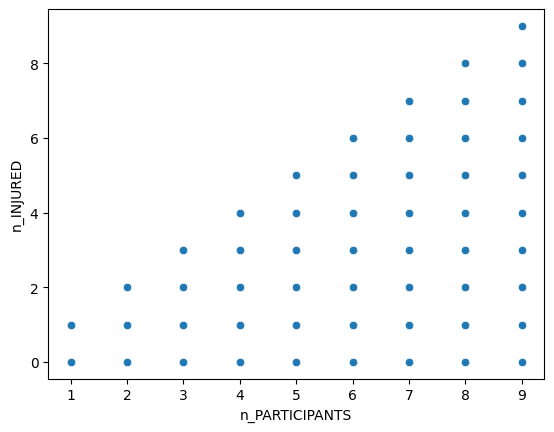

In [19]:
sns.scatterplot(data = dtp, x = 'n_PARTICIPANTS', y = 'n_INJURED')

In [29]:
dtp = dtp.drop(columns = 'Unnamed: 0')

In [30]:
dtp

,REGION,DATE,COORD_L,COORD_W,road_name,road_category,n_VEHICLES,n_PARTICIPANTS,ID,n_DEATHS,n_INJURED,vehicle_failure,non_private_vehicle,russian_vehicle,white_vehicle,black_vehicle,colored_vehicle,drunk_driver,female_driver,escaped,no_seatbelt_injury,n_drunk,n_children,n_cyclists,n_pedestrians,vehicle_age_min,vehicle_age_max,vehicle_age_avg,n_class_a,n_class_b,n_class_c,n_class_d,n_class_e,n_class_s,n_front_drive,n_rear_drive,n_4wd,n_guilty,guilty_share,n_fatal_violations,guilty_exp_avg,exp_avg,road_rank_cat,road_defects_cat,traffic_changes_bin,traffic_changes_cat,road_surface_cat,TYPE_cat,out_of_town,street_rank_cat,weather_interpretable,weather_cat,adj_objects_interpretable,adj_objects_cat,cause_factors_cat,crossing_violation,impaired_driving,interference_violation,license_violation,maneuver_violation,other_violation,pedestrian_violation,sudden_appearance_violation,traffic_control_violation,transport_violation,vehicle_tech_violation,wrong_way,no_lighting,lighting_cat,site_objects_cat,severity,YEAR,MONTH,WEEKDAY,SEASON,is_WEEKEND,HOUR,is_NIGHT,is_PEAK_HOUR,vehicle_age_min_2
0,1,31.01.2015,81.151944,53.740000,Романово - Завьялово - Баево - Камень-на-Оби,5.0,1,3,161242174,0,3,0,0,0,0,0,1,0,0,1,1,0,0,0,0,2003.0,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,4,17.0,17.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,1,0,0,0,1,0,0,0,4,12,2,2015,1,5,1,1,9,0,1,12.0
1,1,30.01.2015,85.018056,51.684444,Куяган - Куяча - Тоурак,6.0,2,3,161105683,0,2,0,1,0,1,0,1,0,0,0,0,0,0,0,0,2002.0,2004.0,2003.0,1,0,0,0,0,0,0,0,0,1,0.5,1,7.0,10.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,2,2015,1,4,1,0,14,0,0,13.0
2,1,30.01.2015,81.250000,53.818056,Барнаул - Камень-на-Оби - граница Новосибирско...,5.0,2,3,161763431,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2005.0,2008.0,2006.5,0,1,0,0,0,0,0,0,0,1,0.5,1,2.0,15.5,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12,1,2015,1,4,1,0,17,0,1,10.0
3,1,24.01.2015,51.000000,84.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160331994,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,2000.0,2000.0,2000.0,0,1,0,0,0,0,0,0,0,1,1.0,2,26.0,26.0,3,5,0,2,1,7,1,0,nothing,5,no_obj,4,18,0,1,0,0,0,0,0,0,1,0,0,0,1,2,12,1,2015,1,5,1,1,19,0,0,15.0
4,1,23.01.2015,84.000000,53.000000,Быканов Мост - Солоновка - Солонешное - границ...,7.0,1,2,160213415,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2003.0,2003.0,2003.0,0,1,0,0,0,0,0,0,0,1,1.0,1,18.0,18.0,3,5,0,2,1,7,1,0,LOW_VISIBILITY,3,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,12,3,2015,1,4,1,0,21,0,0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473183,10011,18.12.2022,55.731164,67.417464,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",5.0,1,1,222679998,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,2020.0,2020.0,2020.0,0,0,0,0,0,0,0,0,1,1,1.0,1,31.0,31.0,3,5,0,2,1,7,1,4,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,0,0,0,1,1,2,3,3,2022,12,6,1,1,15,0,0,2.0
473184,10011,16.06.2024,54.095821,67.629532,"г. Нарьян-Мар - г. Усинск, участок г. Нарьян-М...",6.0,1,2,223892751,0,2,0,0,0,0,1,0,1,0,0,1,2,0,0,0,2023.0,2023.0,2023.0,0,0,0,1,0,0,0,0,1,1,1.0,4,8.0,8.0,3,5,0,2,7,7,1,0,nothing,5,no_obj,4,18,0,0,0,0,0,0,0,0,1,1,0,0,0,0,12,1,2024,6,6,3,1,9,0,1,1.0
473185,10011,04.07.2024,53.607541,67.836463,Подъездная автомобильная дорога к п. Красное,1.0,1,1,223948754,0,1,0,0,0,0,0,1,1,1,0,1,1,0,0,0,2011.0,2011.0,2011.0,0,0,0,0,0,0,0,0,0,1,1.0,1,24.0,24.0,3,13,0,2,2,7,1,4,LOW_VISIBILITY,3,LIVING_OBJ,1,18,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,2,2024,7,3,3,0,9,0,1,13.0
473186,10011,25.08.2024,53.612724,67.837285,Подъездная автомобильная дорога к п. Красное,4.0,1,1,224161731,0,1,0,0,0,0,0,1,1,0,0,1,1,0,0,0,2024.0,2024.0,2024.0,0,0,0,0,0,0,0,0,0,1,1.0,4,95.0,95.0,3,5,0,2,7,4,1,4,nothing,5,SOCIAL_OBJ,3,18,0,0,0,1,0,1,0,0,1,1,0,0,0,0,12,1,2024,

In [31]:
dtp.to_csv('dtp_clear.csv', index = False)